# Importing Libraries

In [1]:
# System
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import date
from time import sleep
import re

In [ ]:
print(f'''
      ******************
      *Library version:*
      ******************
      pandas:{pd.__version__}
      numpy:{np.__version__}
      seaborn:{sns.__version__}
      selenium:{webdriver.__version__}
      re:{re.__version__}
      ''')


# MAIN: Scraper class & analysis functions

In [2]:
class ChromeAuto:
    def __init__(self):
        self.driver_path = '../chromedriver_win32/chromedriver.exe'
        self.options = webdriver.ChromeOptions()
        self.options.add_argument('user-data-dir=JobProfile')
        self.chrome = webdriver.Chrome(
                                        executable_path=self.driver_path,
                                        options=self.options
                                      )
        
    def acessa(self, site):
        self.chrome.get(site)
    
    def sair(self):
        self.chrome.quit()
    
    def insere_job(self, job_to_search):
        try:
            job = self.chrome.find_element_by_css_selector('#cargoDesejado')
            job.clear()
            job.send_keys(job_to_search)
        except Exception as e:
            print('Erro ao inserir nome da vaga de emprego: ',e)
            pass
    
    def insere_city(self, city_or_region):
        try:
            city = self.chrome.find_element_by_css_selector('#cidade')
            city.clear()
            city.send_keys(city_or_region)
        except Exception as e:
            print('Erro ao inserir cidade ou região: ',e)
            pass
    
    def clica_busca(self):
        try:
            search_bttn = self.chrome.find_element_by_css_selector('#formBuscaVagas > div.envolveBtnBuscaVagas.gtm-class > input')
            search_bttn.click()
        except Exception as e:
            print('Erro ao clicar no botão de busca: ',e)
            pass
        
    def one_field_extractor(self,path):
        try:
            field = self.chrome.find_element_by_xpath(path)
            field = field.text
            return field
        except:
            field = pd.NA
            return field
    
    def extractor(self,seq_num):
        """
        Finds the job description box of number seq_num, extracts it's information and returns these informations in a pandas DataFrame
        """
        field_paths = {'name':f'/html/body/div[1]/article/section/ul/li[{seq_num}]/section/div/header/h2/a',
                       'published':f'/html/body/div[1]/article/section/ul/li[{seq_num}]/section/div/header/h2/time',
                       'salary':f'/html/body/div[1]/article/section/ul/li[{seq_num}]/section/div/header/h2/div/strong[1]',
                       'n_jobs':f'/html/body/div[1]/article/section/ul/li[{seq_num}]/section/div/header/h2/div/strong[2]/span[1]',
                       'city':f'/html/body/div[1]/article/section/ul/li[{seq_num}]/section/div/header/h2/div/strong[2]/span[2]/span/a',
                       'description':f'/html/body/div[1]/article/section/ul/li[{seq_num}]/section/div/article/div[1]/div'
                      }
        description_box = self.chrome.find_element_by_xpath(field_paths['name'])
        description_box.click()
        
        try:
            element = WebDriverWait(self.chrome, 2).until(
                EC.presence_of_element_located((By.XPATH, field_paths['description']))
            )
        except:
            pass
        
        return pd.DataFrame({'job_name':[self.one_field_extractor(field_paths['name'])],
                         'publicated_in':[self.one_field_extractor(field_paths['published'])],
                         'salary':[self.one_field_extractor(field_paths['salary'])],
                         'n_jobs':[self.one_field_extractor(field_paths['n_jobs'])],
                         'city':[self.one_field_extractor(field_paths['city'])],
                         'description':[self.one_field_extractor(field_paths['description'])]})
    
    def move_foward(self):
        """
        Moves to the next page, if there is any, and returns True. Else, return False.
        """
        try:
            a = self.chrome.find_element_by_tag_name('a.arrow.next')
            a.click()
            return True
        except:
            return False
    
    def page_scanner(self):
        """
        something
        """
        jobs_information_df = self.extractor(1)
    
        boxes_per_page = 11
        for i in range(2,boxes_per_page):
            try:
                jobs_information_df = pd.concat([jobs_information_df,self.extractor(i)]) 
            except Exception as e:
                print('Erro ao escanear a página: ',e)
                pass
    
        return jobs_information_df

    
if __name__ == '__main__':
    
    
    #Setting scraper and search parameter
    
    chrome = ChromeAuto()
    
    url = 'https://www.catho.com.br/vagas'
    chrome.acessa(url)
    
    job_to_search = input('Escreva a vaga procurada.')
    chrome.insere_job(job_to_search)
    
    city_or_region = input('Escreva a cidade, estado ou região de interesse.')
    chrome.insere_city(city_or_region)
    
    sleep(3)
    chrome.clica_busca()
    
    #Data acquisition
    
    all_jobs = chrome.page_scanner()

    condition = chrome.move_foward()

    while condition == True:
        try:
            df1 = chrome.page_scanner()
            all_jobs = pd.concat([all_jobs, df1])
            sleep(1)
            condition = chrome.move_foward()
        except:
            pass
    
    sleep(3)
    chrome.sair()
    
    #Data manipulation
    
    all_jobs = all_jobs.dropna(how='all').reset_index(drop=True)
    
    all_jobs = all_jobs.fillna(value='no_description')
    
    all_jobs['description'] = all_jobs['description'].apply(lambda x: x.lower().strip())
    
    # Tratando 'De R$ 4.001,00 a R$ 5.000,00' para que fique '4.001,00 - 5.000,00'
    all_jobs['salary'] = all_jobs['salary'].apply(lambda x: x.replace('De','').replace('R$','').replace(' a ','-').strip())
    all_jobs['salary_min'] = all_jobs['salary'].apply(lambda x: x.split('-')[0].strip() if '-' in x else x)
    all_jobs['salary_max'] = all_jobs['salary'].apply(lambda x: x.split('-')[1].strip() if '-' in x else x)

    all_jobs['city'] = all_jobs['city'].apply(lambda x: x.split('(')[0] if '(' in x else x)
    all_jobs['cidade'] = all_jobs['city'].apply(lambda x: x.split('-')[0].strip() if '-' in x else x)
    all_jobs['estado'] = all_jobs['city'].apply(lambda x: x.split('-')[1].strip() if '-' in x else x)
    
    all_jobs = all_jobs[['job_name',
                         'cidade',
                         'estado',
                         'salary',
                         'publicated_in',
                         'n_jobs',
                         'salary_min',
                         'salary_max', 
                         'description']]
    
    #Backup
    name_export = '-'.join([job_to_search.replace(' ','_'),
                            str(date.today()).replace('-','_')])
    
    all_jobs.to_csv(f'./JobProfile/{name_export}.csv', index=False)
    
    
    all_jobs['salary'] = all_jobs['salary'].apply(lambda x: x.replace('De','').replace('R$','').replace(' a ','-').strip())
    all_jobs['salary_min'] = all_jobs['salary'].apply(lambda x: x.split('-')[0].strip() if '-' in x else x)
    all_jobs['salary_max'] = all_jobs['salary'].apply(lambda x: x.split('-')[1].strip() if '-' in x else x)
    
    def numberfy(value):
        '''
        Receives information on wages and translates to float, assigns 0.1 to 'A Combinar' and 0 to 'no_description'. 
        '''
        try:
            a = float(value.replace('.','')
                      .replace(',','.')
                      .replace('Até','')
                      .replace('A Combinar','0.1')
                      .replace('no_description','0')
                      .strip()) 
            return a
        except:
            return pd.NA
    
    all_jobs['salary_min'] = all_jobs['salary_min'].apply(numberfy)
    all_jobs['salary_max'] = all_jobs['salary_max'].apply(numberfy)
    
    # Maximum and minimum salaries without NA and 'A Combinar' or 'no_description'
    def distrib_salarios(all_jobs):
        max_to_plot = all_jobs[all_jobs['salary_max']>0.2]['salary_max'].dropna()
        min_to_plot = all_jobs[all_jobs['salary_min']>0.2]['salary_min'].dropna()


        plt.xlim(0,max_to_plot.max()+500)
        plt.ylim(0,max_to_plot.value_counts().max()+5)

        min_to_plot.plot(kind='hist', 
                         bins=20, 
                         alpha=0.3, 
                         label='limite inferior', 
                         figsize=(10,5))

        max_to_plot.plot(kind='hist', 
                         bins=20, 
                         alpha=0.3, 
                         label='limite superior', 
                         figsize=(10,5))

        plt.legend()
        plt.title(f'Distribuição dos Salários mencionando\n {job_to_search}', fontsize=20)
        plt.ylabel('Frequência')
        plt.xlabel('Salário em reais(R$)')

        return plt.show();
    
    # Importing Portuguese stop words
    pt_stop_words = pd.read_csv('https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt', header=None)
    pt_stop_words.columns = ['stop']

    #flatening the list of lists 
    stop_words = [item for lista in pt_stop_words.values for item in lista]

    # striping possible spaces at beginning or end of strings
    stop_words = [item.strip() for item in stop_words]

    def limpa_ponto(string):
        '''
        Replaces the string punctuation with a space using regex
        '''
        pattern = r"[,.%!+;={}():/\[\]\@\?\"]"
        string = re.sub(pattern,' ',string)
    
        return string

    # For every 'all_jobs' rows: 
    # removes punctuation from description, split into words, keep only one occurence of each and removes stop_words 
    descrp = all_jobs['description'].apply(lambda x: set(item.strip() for item in limpa_ponto(x).split())-set(stop_words))

    # List of the occurrence union of all words used in all scraped descriptions:
    tot_words = [item for lista in descrp.values for item in lista]

    # List of only ONE occurrence of words used in all scraped descriptions:
    set_words = list(set(tot_words))

    # Capturing the frequency of each word occurence
    word_freq = dict()
    for word in set_words:
        word_freq[word] = tot_words.count(word)

    # Pandas series with the sorted frequency of words (descending order)
    ranking = pd.Series(word_freq).sort_values(ascending=False)
    
    
    def check_terms(size, ranking, set_words):
        '''
        Asks for a set of words (comma separated), to check their occurence frequency in the totality of job descriptions.
    
        ranking: pandas series with the frequency of words
    
        size: number of descriptions analysed. Receives all_jobs.shape[0]
    
        set_words: set of words mentioned used in the descriptions without stop_words
        '''
    
    
        searching_terms = input('Digite palavras separadas por vírgula para conferir a frequência de menções nas descrições.')
    
        searching_terms = [item.strip() for item in searching_terms.lower().split(',')]
    
        true_search = [item for item in searching_terms if item in set_words]
        not_present = list(set(searching_terms)-set(true_search))
        #searching_terms = ['sql','python','r','nosql','spark','power','bi']

        print(f'''

*****************************
*Not present on description:*
*****************************
{not_present}

*************************************
*Frequency of searched terms (in %):*
*************************************
{round(ranking[true_search].sort_values(ascending=False)*100/size)}
      
{ranking[true_search].sort_values(ascending=True).plot(kind='barh', title='Specific Terms Frequency (%)')}
              ''')

Escreva a vaga procurada.Cientista de Dados
Escreva a cidade, estado ou região de interesse.São Paulo, SP
Erro ao escanear a página:  Message: element click intercepted: Element <a href="https://www.catho.com.br/vagas/analista-de-business-intelligence/16371211/?origem_apply=busca-de-vagas&amp;entrada_apply=direto" title="Vaga de Analista de Business Intelligence em Barueri - SP" class="viewVagaAction " rel="nofollow">...</a> is not clickable at point (607, 681). Other element would receive the click: <strong class="nomeEmpresa">...</strong>
  (Session info: chrome=81.0.4044.129)

Erro ao escanear a página:  Message: element click intercepted: Element <a href="https://www.catho.com.br/vagas/analista-de-business-intelligence/16581467/?origem_apply=busca-de-vagas&amp;entrada_apply=direto" title="Vaga de Analista de Business Intelligence em São Paulo - SP" class="viewVagaAction " rel="nofollow">...</a> is not clickable at point (607, 603). Other element would receive the click: <div class=

# Data

In [3]:
all_jobs.head()

,job_name,cidade,estado,salary,publicated_in,n_jobs,salary_min,salary_max,description
0,Cientista de Dados,no_description,no_description,"7.000,00","sexta, 24/04",Barueri-SP(1),7000.0,7000.0,"será responsável pela pesquisa, desenvolviment..."
1,Cientista de Dados,no_description,no_description,A Combinar,"segunda, 27/04",São Paulo-SP(1),0.1,0.1,"iniciar um time de ""insight"" e inteligência ar..."
2,Cientista de Dados,no_description,no_description,A Combinar,"quinta, 23/04",São Paulo-SP(1),0.1,0.1,apropriar-se dos projetos de analytics do come...
3,Cientista de Dados,no_description,no_description,A Combinar,"quarta, 22/04",São Paulo-SP(1),0.1,0.1,"analisar dados, construir modelos de predição ..."
4,Cientista de Dados,no_description,no_description,A Combinar,"quinta, 16/04",São Paulo-SP(1),0.1,0.1,linguagens python ou r - estatística básica: c...


In [4]:
all_jobs.shape

(91, 9)

In [5]:
all_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   job_name       91 non-null     object 
 1   cidade         91 non-null     object 
 2   estado         91 non-null     object 
 3   salary         91 non-null     object 
 4   publicated_in  91 non-null     object 
 5   n_jobs         91 non-null     object 
 6   salary_min     91 non-null     float64
 7   salary_max     91 non-null     float64
 8   description    91 non-null     object 
dtypes: float64(2), object(7)
memory usage: 6.5+ KB


# Título das Vagas

In [6]:
all_jobs['job_name'].value_counts().head()

Analista de Business Intelligence            51
Cientista de Dados                           18
Estatístico                                   7
Coordenador de Business Intelligence          2
Cientista de Dados - Produtos Financeiros     1
Name: job_name, dtype: int64

# Cidades Mencionadas

In [7]:
all_jobs['cidade'].value_counts().head()

São Paulo         38
no_description    10
Barueri            7
Rio de Janeiro     5
Brasilia           4
Name: cidade, dtype: int64

# Distribuição dos Salários Mencionados

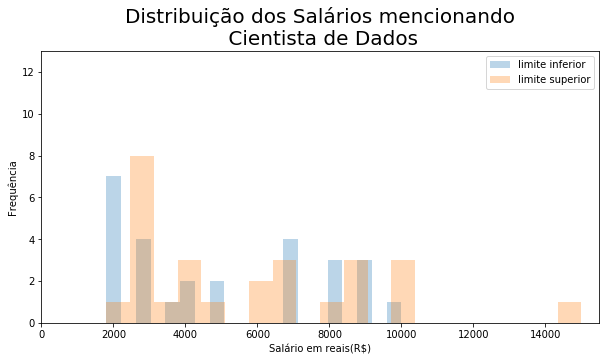

In [8]:
distrib_salarios(all_jobs)

# Terms and Skills on Description 

## General ranking

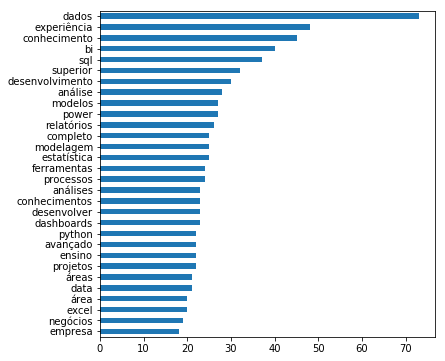

In [9]:
plt.figure(figsize=(6,6))
ranking[0:30].sort_values(ascending=True).plot(kind='barh');

## Checking specific terms frequency

You may check specific terms frequency on the scraped descriptions by running the function below and following the instructions:

Digite palavras separadas por vírgula para conferir a frequência de menções nas descrições.sql,python,spark,etl,skala,airflow,ml,machine,excel,bi,batman,pós,pós-graduação,graduação


*****************************
*Not present on description:*
*****************************
['skala', 'airflow', 'batman', 'ml']

*************************************
*Frequency of searched terms (in %):*
*************************************
bi               44.0
sql              41.0
python           24.0
excel            22.0
etl              19.0
machine          16.0
graduação         8.0
spark             7.0
pós-graduação     4.0
pós               2.0
dtype: float64
      
AxesSubplot(0.125,0.125;0.775x0.755)
              


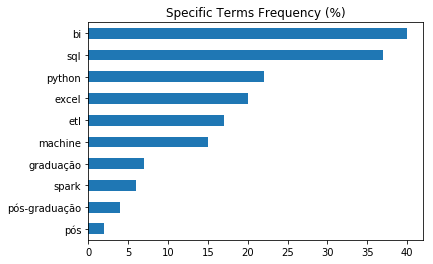

In [10]:
check_terms(size=all_jobs.shape[0], ranking = ranking, set_words = set_words)

In [24]:
word = 'gupy'
all_jobs[all_jobs['description'].str.contains(word)]['description']

13    a gupy é uma empresa de tecnologia que une um ...
Name: description, dtype: object

In [25]:
all_jobs.loc[13,['description']]['description']

'a gupy é uma empresa de tecnologia que une um grupo de pessoas desenvolvedoras, engenheiras e cientistas apaixonados em gerar inovação. somos movidos por grandes desafios e precisamos de pessoas que amem tecnologia, aprendizado constante, e que tenham muita gana para nos ajudarem a transformar a gupy na melhor e maior empresa de recrutamento tech do brasil. atualmente temos um índice de desemprego muito alto no brasil e uma guerra por talentos a todo vapor. por isso, nosso propósito é oferecer contratações mais ágeis, justas e encantadoras para os nossos clientes e candidatos. estamos crescendo muito rápido e criando a cada dia um produto ainda mais poderoso. o segredo disso? as pessoas incríveis que fazem parte conosco dessa construção contínua. dado o cenário da covid-19, algumas de nossas estratégias internas foram revistas e assim, algumas de nossas vagas tiveram seus prazos reajustados ao longo do ano.mas apenas esperar não basta para nós! queremos te preparar para nossas futuras